In [1]:
%load_ext autoreload
%autoreload 2
import os
os.chdir('/home/svcl-oowl/brandon/research/CVPR_2021_REFINE/sil_consistent_at_inference')
print(os.getcwd())

/home/svcl-oowl/brandon/research/CVPR_2021_REFINE/sil_consistent_at_inference


In [2]:
# imports
import pprint
import pickle
import glob
import random
from pathlib import Path
import os
import re

import torch
from tqdm import tqdm
from PIL import Image
import numpy as np
from pytorch3d.renderer import (
    look_at_view_transform
)
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import numpy as np
import plotly.express as px
from plotly.subplots import make_subplots

from utils import general_utils
import deformation.losses as def_losses
from utils.visualization_tools import show_refinement_results


In [3]:
def get_exp_path(exp_name):
    if os.path.exists(os.path.join("out",exp_name)):
        return exp_name
    
    if exp_name == "latest":
        exp_paths = []
        for root, dirs, files in os.walk("out"):
            for d in dirs:
                if "--" in d and len(os.path.join(root,d).split('/'))==2:
                    exp_paths.append(d)
        return sorted(exp_paths)[-1]
    
    exp_path = []
    for root, dirs, files in os.walk("out"):
        for d in dirs:
            if exp_name == d[21:] and len(os.path.join(root,d).split('/'))==2:
                exp_path.append(d)
    if len(exp_path) > 1:
        print(exp_path)
        raise Exception("multiple experiments with that name")
    elif len(exp_path) == 0:
        raise Exception("Couldn't find any matching experiments")
    else:
        return exp_path[0]

In [10]:
n="2021_01_10--12_44_12_job_06"

saved_model_path = "out/{}".format(get_exp_path(n))
print(saved_model_path)
cfg_path = general_utils.get_top_level_cfg_path(saved_model_path, "default.yaml")
print(cfg_path)
cfg = general_utils.load_config(cfg_path, "configs/default.yaml")

gpu_num = 0
device = torch.device("cuda:"+str(gpu_num))

out/2021_01_10--12_44_12_job_06
out/2021_01_10--12_44_12_job_06/job_06.yaml


# Show Adversarial Training Info

In [11]:
df_filenames = ["train_df.pkl", "val_df.pkl"]
losses_to_show = ["sil_loss", "semantic_dis_loss"]

fig = make_subplots(rows=2, cols=len(losses_to_show), subplot_titles=["{}  {}".format(partition, loss)for partition in df_filenames for loss in losses_to_show ])
for row_i, df_filename in enumerate(df_filenames):
    df = pickle.load(open(os.path.join(saved_model_path, df_filename), "rb"))
    df_epoch_avg = df.groupby("epoch", as_index=False).mean()
    display(df_epoch_avg)

    for col_i, loss in enumerate(losses_to_show):
        loss_fig = px.line(df_epoch_avg, x="epoch", y=loss)
        loss_trace = loss_fig['data'][0]
        fig.add_trace(loss_trace, row=row_i+1, col=col_i+1)


fig.update_layout(height=700, width=700*len(losses_to_show))
fig.show()

,epoch,img_sym_loss,l2_loss,lap_smoothness_loss,normal_consistency_loss,semantic_dis_loss,sil_loss,vertex_sym_loss
0,0.0,0.0,0.002640,0.025848,0.102720,2.411317,0.0,0.0
1,5.0,0.0,0.022307,0.025252,0.307076,0.890316,0.0,0.0
2,10.0,0.0,0.025941,0.024606,0.308569,-0.443888,0.0,0.0
3,15.0,0.0,0.022760,0.024314,0.305896,0.027834,0.0,0.0
4,20.0,0.0,0.032197,0.024569,0.317954,-0.692082,0.0,0.0
...,...,...,...,...,...,...,...,...
196,980.0,0.0,0.032200,0.013987,0.144438,0.501477,0.0,0.0
197,985.0,0.0,0.034085,0.013954,0.152177,0.068994,0.0,0.0
198,990.0,0.0,0.032996,0.014013,0.145773,0.082908,0.0,0.0
199,995.0,0.0,0.032826,0.013928,0.147409,0.225737,0.0,0.0


,epoch,img_sym_loss,l2_loss,lap_smoothness_loss,normal_consistency_loss,semantic_dis_loss,sil_loss,vertex_sym_loss
0,0.0,0.0,0.002630,0.026027,0.104177,2.402254,0.0,0.0
1,5.0,0.0,0.022598,0.025650,0.310770,0.902525,0.0,0.0
2,10.0,0.0,0.026455,0.025134,0.310737,-0.425998,0.0,0.0
3,15.0,0.0,0.023175,0.024523,0.309086,0.036129,0.0,0.0
4,20.0,0.0,0.032293,0.024729,0.318185,-0.682439,0.0,0.0
...,...,...,...,...,...,...,...,...
196,980.0,0.0,0.033497,0.014302,0.191791,0.531039,0.0,0.0
197,985.0,0.0,0.034598,0.014014,0.197029,0.092644,0.0,0.0
198,990.0,0.0,0.033607,0.014203,0.190900,0.108609,0.0,0.0
199,995.0,0.0,0.033975,0.014182,0.194514,0.247735,0.0,0.0


# Show Adversarial Training Results

In [6]:
# displays meshes at the predicted pose
def show_meshes(cfg, device, saved_model_path, only_show_instances=[], num_novel_view=3, print_instances=False, descending=True, early_break=True):
    input_dir_img = cfg['semantic_dis_training']['gen_dir_img']
    input_dir_mesh = cfg['semantic_dis_training']['gen_dir_mesh']
    
    cached_pred_poses = pickle.load(open(cfg['semantic_dis_training']["gen_poses"], "rb"))
    
    # getting paths of all processed meshes, keyed by instance name
    processed_paths = list(Path(saved_model_path).rglob('*.obj'))
    processed_paths_dict = {}
    for path in processed_paths:
        instance_name = str(path).split('/')[-1][:-4]
        if instance_name not in processed_paths_dict:
            processed_paths_dict[instance_name] = [path]
        else:
            processed_paths_dict[instance_name].append(path)
    
    for instance_name in processed_paths_dict:
        if len(only_show_instances) == 0 or instance_name in only_show_instances:
            for processed_mesh_path in sorted(processed_paths_dict[instance_name], key= lambda x : int(re.sub("[^0-9]","",str(x).split('/')[-2])), reverse=descending):
                if print_instances:
                    print(instance_name)
                    print(processed_mesh_path)
                    
                input_image = Image.open(os.path.join(input_dir_img, instance_name+".png"))
                with torch.no_grad():
                    mesh_original = general_utils.load_untextured_mesh(os.path.join(input_dir_mesh, instance_name+".obj"), device)
                    mesh_processed = general_utils.load_untextured_mesh(processed_mesh_path, device)

                # rendering original and processed mesh at predicted pose
                pred_dist = cached_pred_poses[instance_name]['dist']
                pred_elev = cached_pred_poses[instance_name]['elev']
                pred_azim = cached_pred_poses[instance_name]['azim']
                
                show_refinement_results(input_image, mesh_original, mesh_processed, pred_dist, pred_elev, pred_azim, device)
                if early_break:
                    break

In [7]:
def show_latest_meshes(keyword):
    eval_dirs = []
    for root, dirs, files in os.walk(saved_model_path):
        for d in dirs:
            if keyword in d:
                eval_dirs.append(d)
    print(eval_dirs)
    eval_dirs = sorted(eval_dirs)
    #eval_dirs = sorted(eval_dirs, key= lambda x: int(x.replace("eval_", "")))
    latest_eval_dir = os.path.join(saved_model_path, eval_dirs[-1])
    print("Latest eval dir: {}\n".format(latest_eval_dir))

    show_meshes(cfg, device, latest_eval_dir, print_instances=True)
    
def split(a, n):
    k, m = divmod(len(a), n)
    return list((a[i * k + min(i, m):(i + 1) * k + min(i + 1, m)] for i in range(n)))

def show_meshes_throughout(keyword, only_show_instances, num_show=10):
    eval_dirs = []
    for root, dirs, files in os.walk(saved_model_path):
        for d in dirs:
            if keyword in d:
                eval_dirs.append(d)
    eval_dirs = sorted(eval_dirs)
    show_eval_dirs = [d[-1] for d in split(eval_dirs, num_show)]
    for d in show_eval_dirs:
        full_dir = os.path.join(saved_model_path,d)
        show_meshes(cfg, device, full_dir, print_instances=True, only_show_instances=only_show_instances)
        print("=========================================================================================================================================================================")
        print("=========================================================================================================================================================================")

In [ ]:
show_latest_meshes("_train")

['eval_0305_val', 'eval_0330_val', 'eval_0165_val', 'eval_0970_val', 'eval_0685_val', 'eval_0975_val', 'eval_0135_val', 'eval_0820_val', 'eval_0660_val', 'eval_0240_val', 'eval_0895_val', 'eval_0010_val', 'eval_0670_val', 'eval_0995_val', 'eval_0175_val', 'eval_0255_val', 'eval_0655_val', 'eval_0120_val', 'eval_0075_val', 'eval_0070_val', 'eval_0250_val', 'eval_0385_val', 'eval_0315_val', 'eval_0705_val', 'eval_0740_val', 'eval_0575_val', 'eval_0635_val', 'eval_0915_val', 'eval_0925_val', 'eval_0465_val', 'eval_0825_val', 'eval_0280_val', 'eval_0095_val', 'eval_0630_val', 'eval_0675_val', 'eval_0470_val', 'eval_0065_val', 'eval_0610_val', 'eval_0890_val', 'eval_0365_val', 'eval_0355_val', 'eval_0290_val', 'eval_0570_val', 'eval_0930_val', 'eval_0435_val', 'eval_0295_val', 'eval_0520_val', 'eval_0650_val', 'eval_0965_val', 'eval_0905_val', 'eval_0145_val', 'eval_0885_val', 'eval_0415_val', 'eval_0050_val', 'eval_0360_val', 'eval_0485_val', 'eval_0310_val', 'eval_0945_val', 'eval_0755_va

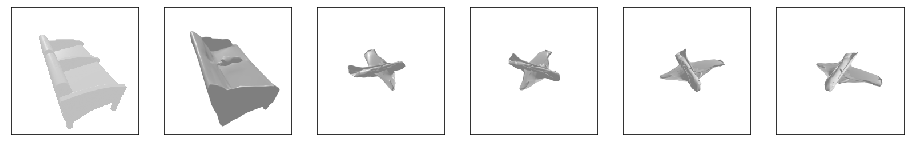

1ab42ccff0f8235d979516e720d607b8
out/2021_01_10--12_44_12_job_06/eval_0999_val/1ab42ccff0f8235d979516e720d607b8.obj


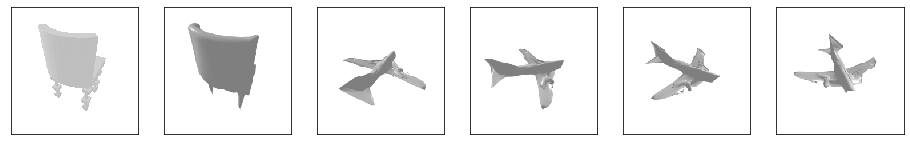

19e2321df1141bf3b76e29c9c43bc7aa
out/2021_01_10--12_44_12_job_06/eval_0999_val/19e2321df1141bf3b76e29c9c43bc7aa.obj


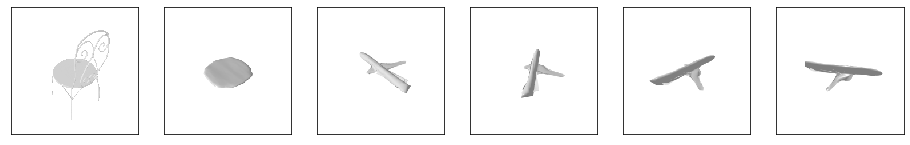

10c08a28cae054e53a762233fffc49ea
out/2021_01_10--12_44_12_job_06/eval_0999_val/10c08a28cae054e53a762233fffc49ea.obj


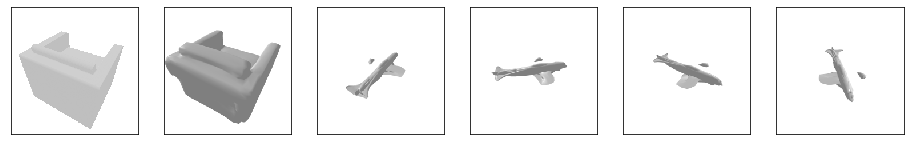

104256e5bb73b0b719fb4103277a6b93
out/2021_01_10--12_44_12_job_06/eval_0999_val/104256e5bb73b0b719fb4103277a6b93.obj


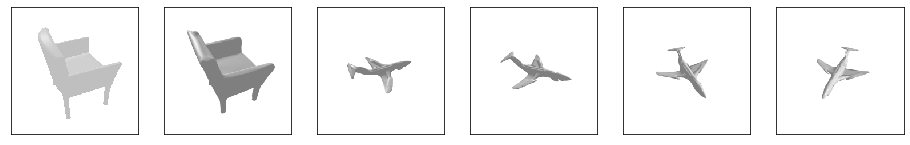

1007e20d5e811b308351982a6e40cf41
out/2021_01_10--12_44_12_job_06/eval_0999_val/1007e20d5e811b308351982a6e40cf41.obj


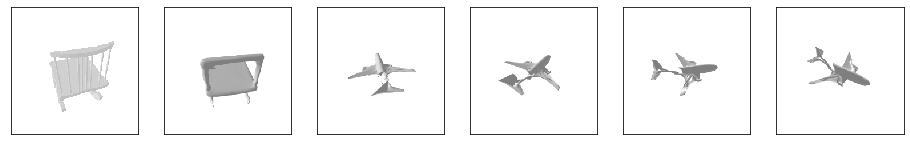

120735afde493c277ff6ace05b36a5
out/2021_01_10--12_44_12_job_06/eval_0999_val/120735afde493c277ff6ace05b36a5.obj


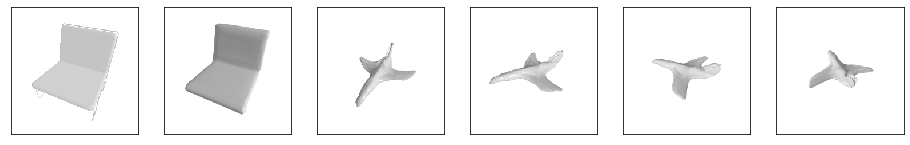

1986eeb9bb594bf9a6d7a9f3c5f7bb41
out/2021_01_10--12_44_12_job_06/eval_0999_val/1986eeb9bb594bf9a6d7a9f3c5f7bb41.obj


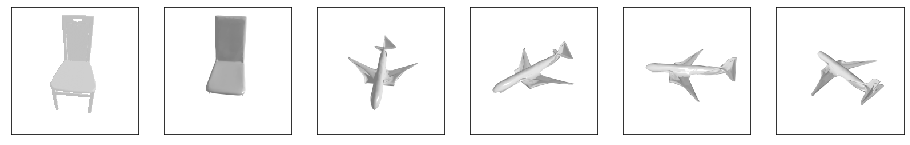

17b558e72a4d76ef8517036a5ca6b1c7
out/2021_01_10--12_44_12_job_06/eval_0999_val/17b558e72a4d76ef8517036a5ca6b1c7.obj


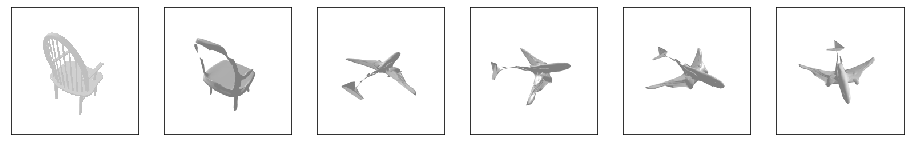

11e521e41ff6a64922e4620665c23c97
out/2021_01_10--12_44_12_job_06/eval_0999_val/11e521e41ff6a64922e4620665c23c97.obj


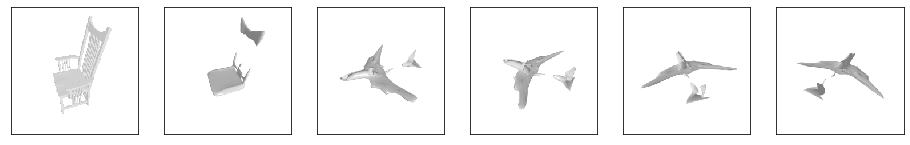

10a1783f635b3fc181dff5c2e57ad46e
out/2021_01_10--12_44_12_job_06/eval_0999_val/10a1783f635b3fc181dff5c2e57ad46e.obj


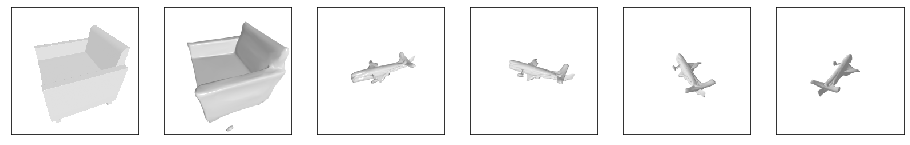

19a3ac2ec0312e13c8687ff9b0b4e4ac
out/2021_01_10--12_44_12_job_06/eval_0999_val/19a3ac2ec0312e13c8687ff9b0b4e4ac.obj


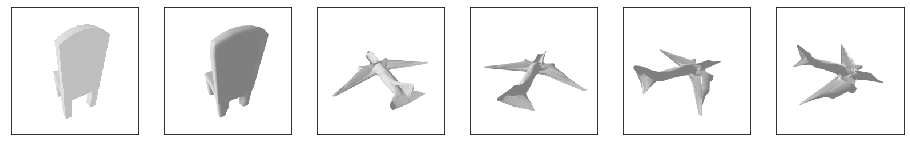

1820138eca42749262e4024c69de065d
out/2021_01_10--12_44_12_job_06/eval_0999_val/1820138eca42749262e4024c69de065d.obj


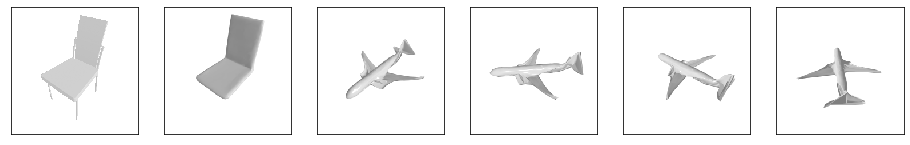

17e916fc863540ee3def89b32cef8e45
out/2021_01_10--12_44_12_job_06/eval_0999_val/17e916fc863540ee3def89b32cef8e45.obj


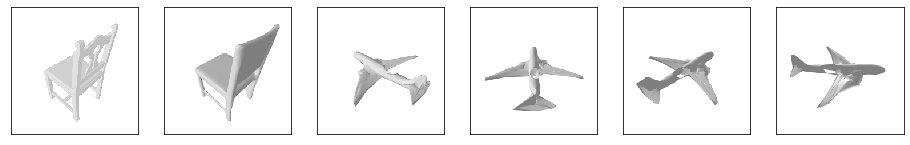

13c18609602e4ced37b2bb75885cfc44
out/2021_01_10--12_44_12_job_06/eval_0999_val/13c18609602e4ced37b2bb75885cfc44.obj


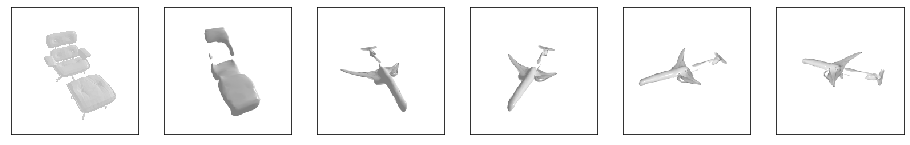

19ff1d5665c1a68677b8fc2abf845259
out/2021_01_10--12_44_12_job_06/eval_0999_val/19ff1d5665c1a68677b8fc2abf845259.obj


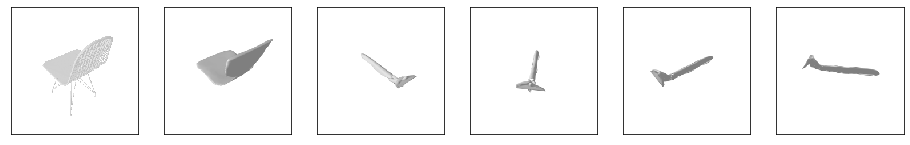

19ee0ca97ed377fb69fffd0daafdccbc
out/2021_01_10--12_44_12_job_06/eval_0999_val/19ee0ca97ed377fb69fffd0daafdccbc.obj


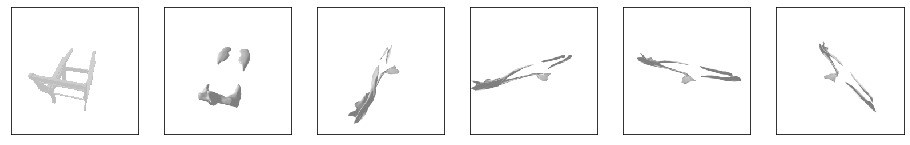

11c7675a3dbc0d32f7287e3d21227e43
out/2021_01_10--12_44_12_job_06/eval_0999_val/11c7675a3dbc0d32f7287e3d21227e43.obj


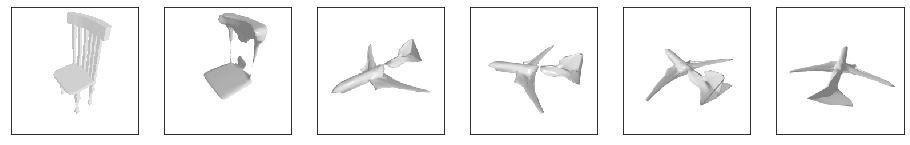

108238b535eb293cd79b19c7c4f0e293
out/2021_01_10--12_44_12_job_06/eval_0999_val/108238b535eb293cd79b19c7c4f0e293.obj


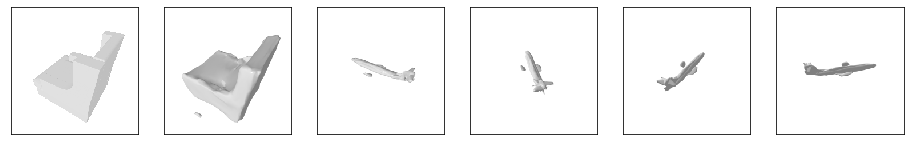

100b18376b885f206ae9ad7e32c4139d
out/2021_01_10--12_44_12_job_06/eval_0999_val/100b18376b885f206ae9ad7e32c4139d.obj


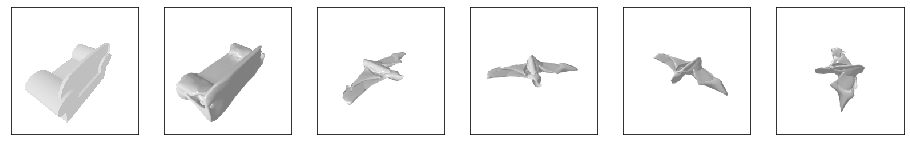

1997d5827caf81df67d783b4714d4324
out/2021_01_10--12_44_12_job_06/eval_0999_val/1997d5827caf81df67d783b4714d4324.obj


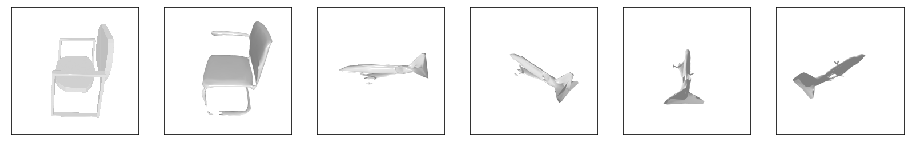

184c07776b38d92e35836c728d324152
out/2021_01_10--12_44_12_job_06/eval_0999_val/184c07776b38d92e35836c728d324152.obj


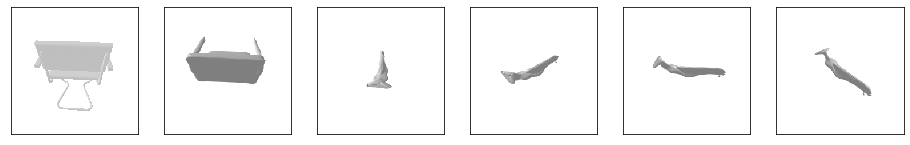

115b11a77b8d8c3c110a27d1d78196
out/2021_01_10--12_44_12_job_06/eval_0999_val/115b11a77b8d8c3c110a27d1d78196.obj


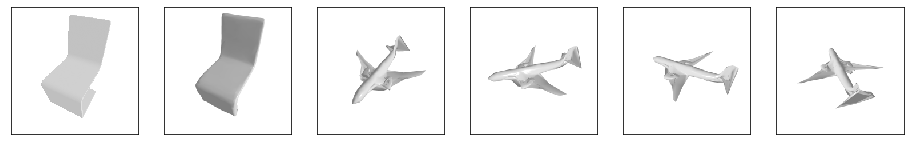

17dee0cfe9a370b134bce1184e175df4
out/2021_01_10--12_44_12_job_06/eval_0999_val/17dee0cfe9a370b134bce1184e175df4.obj


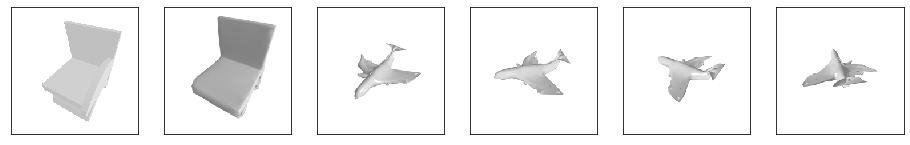

11f1511799d033ff7962150cab9888d6
out/2021_01_10--12_44_12_job_06/eval_0999_val/11f1511799d033ff7962150cab9888d6.obj


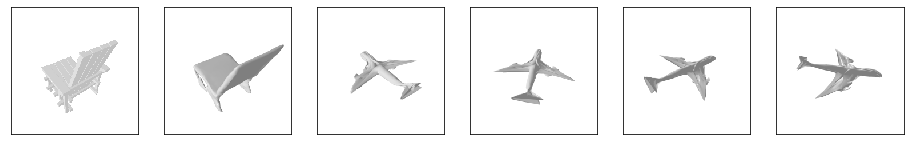

122a480cfcdd742650c626aa72455dae
out/2021_01_10--12_44_12_job_06/eval_0999_val/122a480cfcdd742650c626aa72455dae.obj


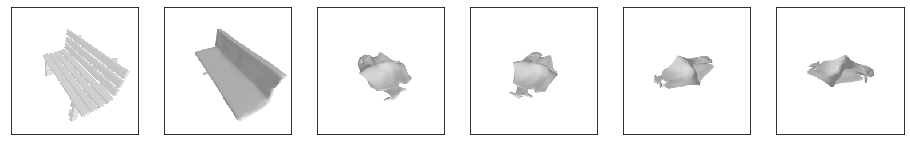

179b88264e7f96468b442b160bcfb7fd
out/2021_01_10--12_44_12_job_06/eval_0999_val/179b88264e7f96468b442b160bcfb7fd.obj


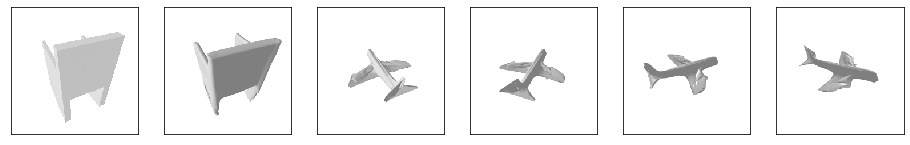

183974726abab0454aa6191ddaf4b676
out/2021_01_10--12_44_12_job_06/eval_0999_val/183974726abab0454aa6191ddaf4b676.obj


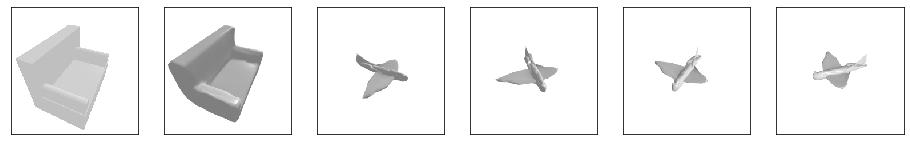

11d8814ed60b54002449009b96f8a6ed
out/2021_01_10--12_44_12_job_06/eval_0999_val/11d8814ed60b54002449009b96f8a6ed.obj


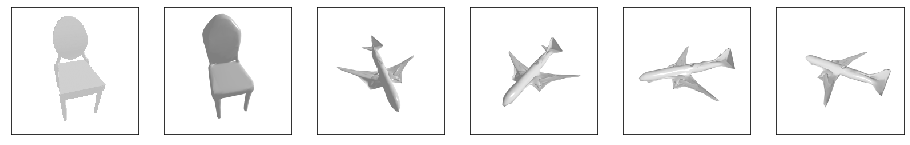

1512e3c41de7a461e10a48f2bbb9bef4
out/2021_01_10--12_44_12_job_06/eval_0999_val/1512e3c41de7a461e10a48f2bbb9bef4.obj


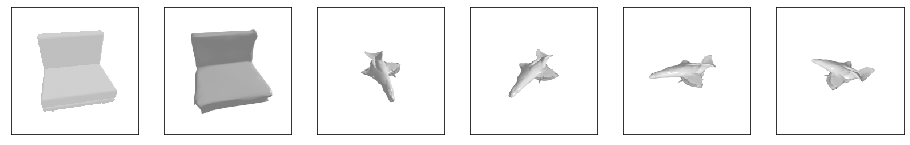

11b7c86fc42306ec7e7e25239e7b8f85
out/2021_01_10--12_44_12_job_06/eval_0999_val/11b7c86fc42306ec7e7e25239e7b8f85.obj


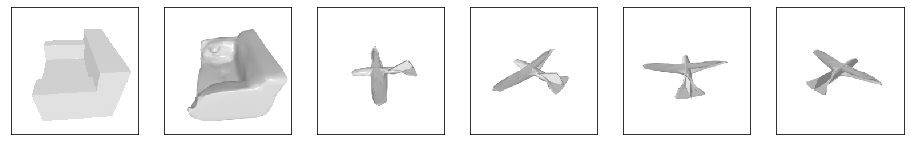

1033ee86cc8bac4390962e4fb7072b86
out/2021_01_10--12_44_12_job_06/eval_0999_val/1033ee86cc8bac4390962e4fb7072b86.obj


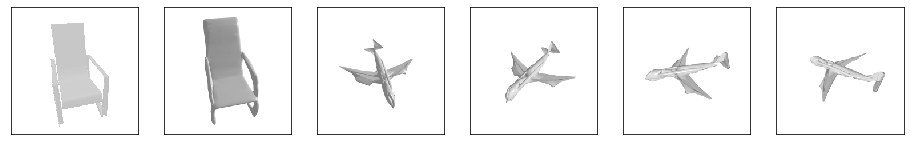

117bd6da01905949a81116f5456ee312
out/2021_01_10--12_44_12_job_06/eval_0999_val/117bd6da01905949a81116f5456ee312.obj


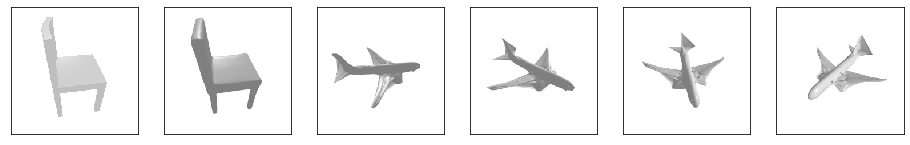

177849848dc83fb9cb85ba5866080618
out/2021_01_10--12_44_12_job_06/eval_0999_val/177849848dc83fb9cb85ba5866080618.obj


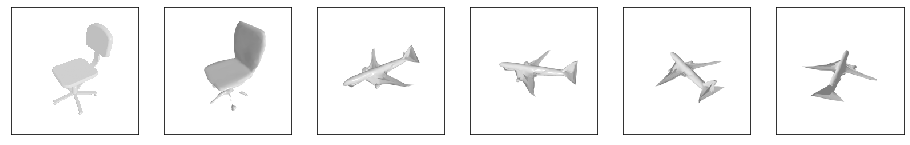

1006be65e7bc937e9141f9b58470d646
out/2021_01_10--12_44_12_job_06/eval_0999_val/1006be65e7bc937e9141f9b58470d646.obj


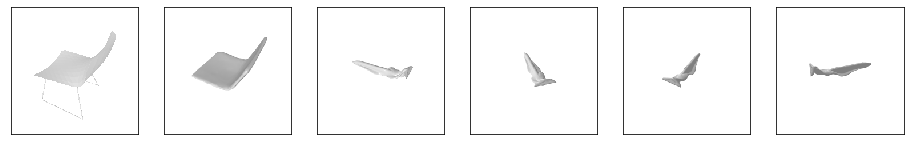

11dba3a8d7b7210f5ff61a3a2a0e2484
out/2021_01_10--12_44_12_job_06/eval_0999_val/11dba3a8d7b7210f5ff61a3a2a0e2484.obj


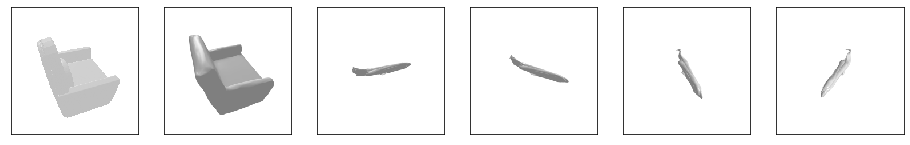

103b75dfd146976563ed57e35c972b4b
out/2021_01_10--12_44_12_job_06/eval_0999_val/103b75dfd146976563ed57e35c972b4b.obj


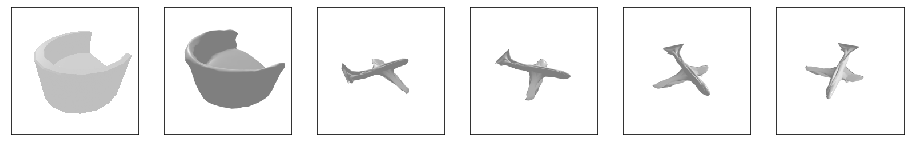

18fe5de83a17c6b5876b399a99a15c0f
out/2021_01_10--12_44_12_job_06/eval_0999_val/18fe5de83a17c6b5876b399a99a15c0f.obj


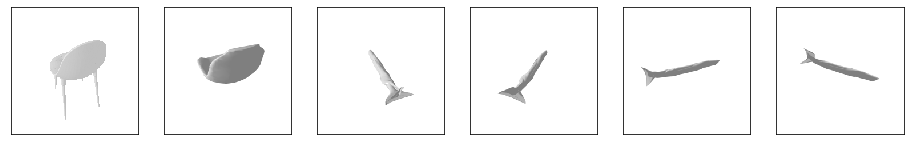

11fa9b044482814ef91663a74ccd2338
out/2021_01_10--12_44_12_job_06/eval_0999_val/11fa9b044482814ef91663a74ccd2338.obj


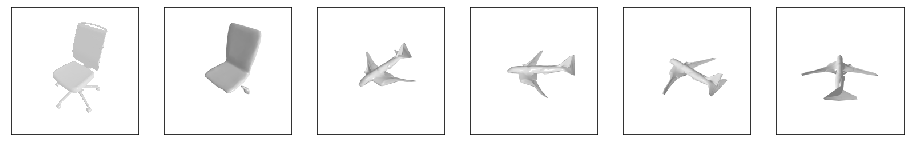

13d3462293023fe71f530727405d60cf
out/2021_01_10--12_44_12_job_06/eval_0999_val/13d3462293023fe71f530727405d60cf.obj


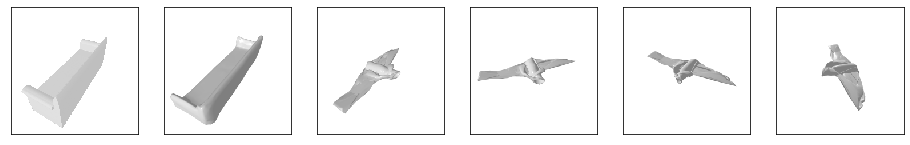

In [12]:
show_latest_meshes("_val")

In [ ]:
show_meshes_throughout("_val", ["1492ab4cf7a345e34b6f686803e61ffd"])

In [ ]:
best_ep=250
show_meshes(cfg, device, "out/2021_01_10--12_11_09_job_01/eval_0{}_val".format(best_ep), print_instances=True)

In [ ]:
# show a mesh throughout iterations
#instances_to_show = ["ee4858f78dc33591100e9bd5c4b0af54", "e0efbc4e240b9cc235836c728d324152", "d6ac690c293a492d2d2a5d4c4022b4c6", "d20de927fd1b15ef104c86562c321749"]
#instances_to_show = ["e7d4a3cca8edfde4829113e62386fd50", "d97a4a6f84f40854f51fa0238791f5dc", "ce9cedc58c77aab4b5a19b1840ec7af"]
instances_to_show = ["d30e58a2361785683fb0851e9bc87551", "cc25ba35b3f6e8d3d064b65ccd89778c", "d4326cd55ed8333f6a059e1fc701f06", "d02f9ae175fa83d3e6fe3612af521500", "d1291956cb0983ee7085b4353236aad",
            "ee4858f78dc33591100e9bd5c4b0af54", "e0efbc4e240b9cc235836c728d324152", "d6ac690c293a492d2d2a5d4c4022b4c6", "d20de927fd1b15ef104c86562c321749",
            "e7d4a3cca8edfde4829113e62386fd50", "d97a4a6f84f40854f51fa0238791f5dc", "ce9cedc58c77aab4b5a19b1840ec7af"]

show_meshes(cfg, device, saved_model_path, instances_to_show, print_instances=True, descending=True)

# New heading

In [ ]:
for i in range(1,19):
    n = ("job_{:02}".format(i))
    saved_model_path = "out/{}".format(get_exp_path(n))
    print(saved_model_path)
    cfg_path = glob.glob(os.path.join(saved_model_path, "job_*.yaml"))[0]
    print(cfg_path)
    cfg = general_utils.load_config(cfg_path, "configs/default.yaml")
    
    # show a mesh throughout iterations
    #instance_to_show = ["ee4858f78dc33591100e9bd5c4b0af54", "e0efbc4e240b9cc235836c728d324152", "d6ac690c293a492d2d2a5d4c4022b4c6", "d20de927fd1b15ef104c86562c321749"]
    instance_to_show = ["e7d4a3cca8edfde4829113e62386fd50", "d97a4a6f84f40854f51fa0238791f5dc", "ce9cedc58c77aab4b5a19b1840ec7af"]
    show_meshes(cfg, device, saved_model_path, instance_to_show, print_instances=True, descending=True)

    print("=================================================================================================")
    print("=================================================================================================")